# Model selection

In [1]:
import pandas as pd
import sys
import os
sys.path.append("../")
from definitions import ROOT_DIR
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## Model specific data preprocessing

In [2]:
data_folder = os.path.join(ROOT_DIR, 'data/interim')
figures_folder = os.path.join(ROOT_DIR, 'reports/figures')
checkpoints_folder = os.path.join(ROOT_DIR, 'models')
CHECKPOINTS_PATH = os.path.join(checkpoints_folder, 'v2_keras_model.h5')
MODEL_PATH = os.path.join(checkpoints_folder, 'v2_keras_model.keras')

In [3]:
data = pd.read_csv(os.path.join(data_folder, 'data_processed.csv'))
films = pd.read_csv(os.path.join(data_folder, 'films_processed.csv'))
users = pd.read_csv(os.path.join(data_folder, 'user_processed.csv'))

In [4]:
shuffled_ratings = data.sample(frac=1., random_state=42)

Users = shuffled_ratings['user_emb_id'].values
print('Users:', Users, ', shape =', Users.shape)

Movies = shuffled_ratings['item_emb_id'].values
print('Movies:', Movies, ', shape =', Movies.shape)

# Shuffling ratings
Ratings = shuffled_ratings['rating'].values
print('Ratings:', Ratings, ', shape =', Ratings.shape)

Users: [876 814  93 ... 436 283 221] , shape = (100000,)
Movies: [380 601 430 ... 474 321 199] , shape = (100000,)
Ratings: [4 3 4 ... 3 3 3] , shape = (100000,)


### Train and Val splitting

In [5]:
Users_train = Users[:80000]
Movies_train = Movies[:80000]
Ratings_train = Ratings[:80000]

Users_test = Users[80000:]
Movies_test = Movies[80000:]
Ratings_test = Ratings[80000:]

In [6]:
max_userid = data['user_id'].drop_duplicates().max()
max_movieid = data['item_id'].drop_duplicates().max()

## Defining the model

**NOTE:** I had some really big troubles with serializing a custom TF model, so I declared it in a custom file 'models/model.py'.

In [7]:
sys.path.append(checkpoints_folder)
import model as create_model

In [8]:
K_FACTORS = 100 # The number of dimensional embeddings for movies and users
model = create_model.get_model(max_userid, max_movieid, K_FACTORS)
model.compile(loss='mse', optimizer='adamax')

### Visualizing the model

In [9]:
def plot_model(model):
  return tf.keras.utils.plot_model(
            model, show_shapes=True, expand_nested=True, to_file=os.path.join(figures_folder, 'v2_keras_model.png'))

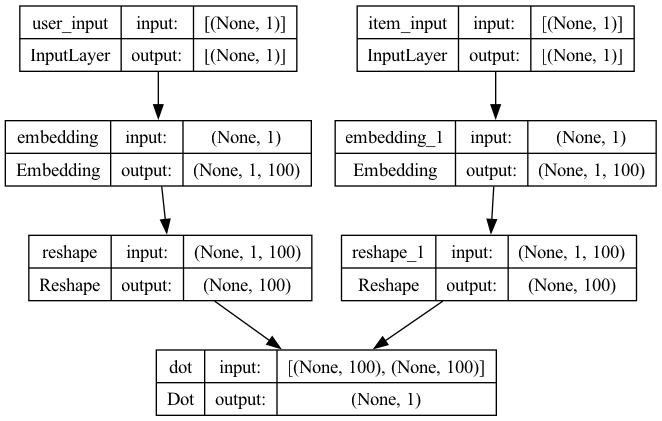

In [10]:
plot_model(model)

## Training the model

In [199]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
callbacks = [EarlyStopping('val_loss', patience=3), 
             ModelCheckpoint(CHECKPOINTS_PATH, save_best_only=True)]
             
history = model.fit([Users_train, Movies_train], Ratings_train, epochs=100, 
                    validation_data=([Users_test, Movies_test], Ratings_test), verbose=2, callbacks=callbacks)

Epoch 1/100


2500/2500 - 1s - loss: 13.7372 - val_loss: 13.6705 - 1s/epoch - 537us/step
Epoch 2/100


/Users/tolyasek/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2500/2500 - 1s - loss: 13.6424 - val_loss: 13.4563 - 1s/epoch - 479us/step
Epoch 3/100
2500/2500 - 1s - loss: 12.9991 - val_loss: 12.2710 - 1s/epoch - 448us/step
Epoch 4/100
2500/2500 - 1s - loss: 11.0285 - val_loss: 9.6267 - 1s/epoch - 458us/step
Epoch 5/100
2500/2500 - 1s - loss: 8.0476 - val_loss: 6.7228 - 1s/epoch - 446us/step
Epoch 6/100
2500/2500 - 1s - loss: 5.6649 - val_loss: 4.9542 - 1s/epoch - 443us/step
Epoch 7/100
2500/2500 - 1s - loss: 4.3018 - val_loss: 3.9236 - 1s/epoch - 450us/step
Epoch 8/100
2500/2500 - 1s - loss: 3.4553 - val_loss: 3.2387 - 1s/epoch - 457us/step
Epoch 9/100
2500/2500 - 1s - loss: 2.8767 - val_loss: 2.7601 - 1s/epoch - 447us/step
Epoch 10/100
2500/2500 - 1s - loss: 2.4639 - val_loss: 2.4092 - 1s/epoch - 447us/step
Epoch 11/100
2500/2500 - 1s - loss: 2.1589 - val_loss: 2.1445 - 1s/epoch - 449us/step
Epoch 12/100
2500/2500 - 1s - loss: 1.9265 - val_loss: 1.9405 - 1s/epoch - 452us/step
Epoch 13/100
2500/2500 - 1s - loss: 1.7461 - val_loss: 1.7797 - 1s/ep

### Best val loss

Here I am going to calculate RMSE instead of MSE.

In [200]:
import math

min_val_loss, idx = min((val, idx) for (idx, val) in enumerate(history.history['val_loss']))
print('Minimum RMSE at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(math.sqrt(min_val_loss)))

Minimum RMSE at epoch 79 = 0.9282


It means that in average model predictions differ from true values by ~ 0.9

### Visualizing training results

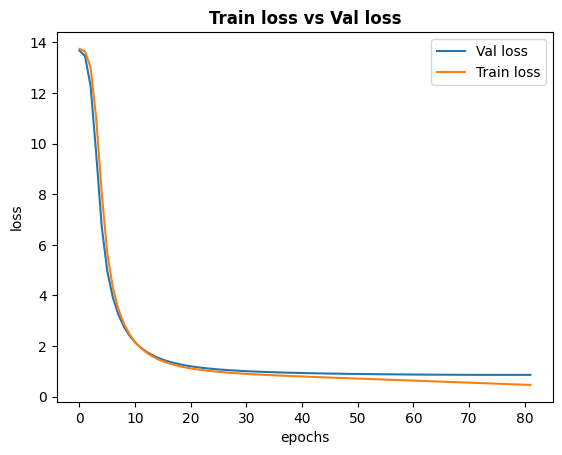

In [201]:
plt.plot(history.history['val_loss'], label="Val loss")
plt.plot(history.history['loss'],  label="Train loss")
plt.title('Train loss vs Val loss', fontweight='bold')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.savefig(os.path.join(figures_folder, 'v2_keras_model_training.png'))
plt.show()

## Predict the ratings

In [11]:
trained_model = create_model.get_model(max_userid, max_movieid, K_FACTORS)
trained_model.load_weights(CHECKPOINTS_PATH)

In [13]:
%%capture
user_ratings = data[['user_id', 'item_id', 'rating']]
user_ids = data['user_id']
item_ids = data['item_id']
user_ratings['prediction'] = trained_model.rate(user_ids, item_ids)
user_ratings.sort_values(by='rating', 
                         ascending=False)

In [14]:
%%capture
user_ratings['prediction_rounded'] = user_ratings['prediction'].round().astype(int)

In [15]:
user_ratings.head(4)

,user_id,item_id,rating,prediction,prediction_rounded
0,196,242,3,3.963603,4
1,186,302,3,3.570793,4
2,22,377,1,2.106547,2
3,244,51,2,3.452192,3


## Analyzing results

### Accuracy

In [19]:
print('Final accuracy:')
(user_ratings['prediction_rounded'] == user_ratings['rating']).sum() / user_ratings.shape[0]

Final accuracy:


0.53716

### Confusion matrix

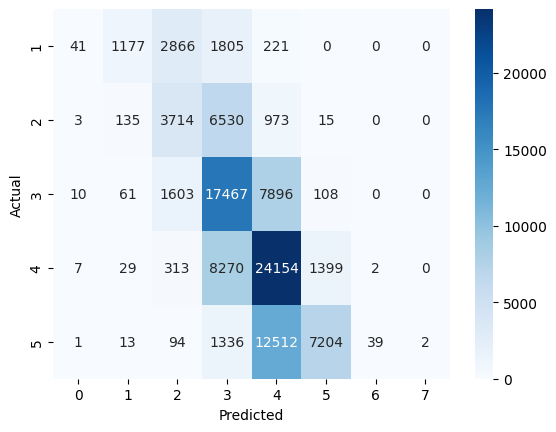

In [49]:
import seaborn as sns

confusion_matrix = pd.crosstab(user_ratings['rating'], user_ratings['prediction_rounded'], rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.savefig(os.path.join(figures_folder, 'v2_keras_model_confusion_mtr.png'))
plt.show()

**NOTE:** Lets assume that when we will predict user rankings for all films, then it will have approximately the same distribtuion of values in confusion matrix. Lets also assume that user loves a films, when he rates it like 4 or 5. In such case we can suggest films with rating prediction of 5. What will happen? 

User will give:
1. '5' to 82% of films
2. '4' to 16% of films
3. '3' to 1% of films
4. '2' to 0.1% of films
5. '1' to 0.0% of films

This basically means that user will like 98.5% of films that are commended. But what about amount of the recommeded films? Will it be good enough? We can face lack of recommendations problem, if we pick only top prediction films. Lets find it out.

## Predicting the films

This is data, which consists of pairs (user_id, item_id) of films, which user have not watched (rated).

In [48]:
unseen_films = pd.read_csv(os.path.join(data_folder, 'unseen_films.csv'))
unseen_films.head()

,user_id,item_id
0,1,273
1,1,274
2,1,275
3,1,276
4,1,277


Predicting rating for this data.

In [50]:
rating = predict_rating(unseen_films['user_id'], unseen_films['item_id'])

In [52]:
unseen_films['rating'] = rating

In [53]:
unseen_films.head()

,user_id,item_id,rating
0,1,273,3.916391
1,1,274,3.134804
2,1,275,4.168838
3,1,276,4.408715
4,1,277,3.868743


Getting recommedations - films with predicted rating of 5 (>= 4.5 after rounding).

In [54]:
recommendations = unseen_films[unseen_films['rating'] >= 4.5]
recommendations.head()

,user_id,item_id,rating
12,1,285,4.873541
84,1,357,4.688702
135,1,408,4.899974
154,1,427,4.982358
155,1,428,4.577764


Now I want to find out how many recommendations are there in average per one user.

In [66]:
counts = recommendations.groupby(['user_id']).count().drop(['rating'], axis=1)
counts.head(2)

,item_id
user_id,
1,29
2,3


In [72]:
bins = [0, 2, 6, 10, 30, 100, 200, 600]

# Use pd.cut to categorize the values into bins
counts['count_ranges'] = pd.cut(counts['item_id'], bins=bins)

# Use value_counts to count occurrences in each range
count_ranges_counts = counts['count_ranges'].value_counts().sort_index()

count_ranges_counts

(0, 2]        110
(2, 6]        106
(6, 10]        60
(10, 30]      119
(30, 100]     118
(100, 200]     33
(200, 600]     31
Name: count_ranges, dtype: int64